# 데이터 준비 (수정 안해도 되는 부분)
## 구글 드라이브에 open.zip (대회 데이터 파일) 을 저장해놓기

In [ ]:
# 구글 드라이브 연동하기

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
# 드라이브 안에 있는 open.zip을 코랩의 현재 디렉토리에 압축해제하기

!unzip /content/drive/MyDrive/open.zip -d ./

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./train/YGLREVCI.ogg    
  inflating: ./train/YGLXWFHV.ogg    
  inflating: ./train/YGMDZXNH.ogg    
  inflating: ./train/YGNBHIJR.ogg    
  inflating: ./train/YGNYUVFD.ogg    
  inflating: ./train/YGOBSHQC.ogg    
  inflating: ./train/YGOHGPYC.ogg    
  inflating: ./train/YGOJCZPI.ogg    
  inflating: ./train/YGOPJRGB.ogg    
  inflating: ./train/YGOUDQAW.ogg    
  inflating: ./train/YGOVHKGM.ogg    
  inflating: ./train/YGPAVGYX.ogg    
  inflating: ./train/YGPBFKRL.ogg    
  inflating: ./train/YGPKBYES.ogg    
  inflating: ./train/YGPLMREG.ogg    
  inflating: ./train/YGPPRAEG.ogg    
  inflating: ./train/YGQYKVKC.ogg    
  inflating: ./train/YGSHBSPQ.ogg    
  inflating: ./train/YGSOQIHH.ogg    
  inflating: ./train/YGSVKSRM.ogg    
  inflating: ./train/YGTHJFJE.ogg    
  inflating: ./train/YGTVQNQS.ogg    
  inflating: ./train/YGTZZFQG.ogg    
  inflating: ./train/YGUHCKOU.ogg    
  inflating: ./train/YGUXKMIZ.ogg    
  inflating: .

In [2]:
# 필수 라이브러리 다운로드

!pip3 install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [3]:
# 필요한 라이브러리, pytorch import 하기 + gpu우선 사용하기

import librosa

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torchmetrics
import os
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# 재현성을 위해 SEED값을 고정하는 SEED를 설정해줍니다.
# 수정안해도됨

class Config:
    SR = 32000
    N_MFCC = 13
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 96
    N_EPOCHS = 5
    LR = 3e-4
    # Others
    SEED = 42

CONFIG = Config()

In [5]:
# 재현성 보장 함수, 수정 안해도됨

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

# 데이터 전처리

In [6]:
# 전처리(학습데이터 불러오기)
# test_size 수정가능

from sklearn.model_selection import KFold

df = pd.read_csv('/content/train.csv')
# csv파일을 불러오기, 이 csv파일 안에는 train이라는 폴더 내에 있는 실제 음성 데이터들의 경로가 들어있음

train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, random_state=CONFIG.SEED)
# 여기서는 모델을 훈련하기위해 train.csv에 적혀있는 id를 기준으로 train 폴더 내의 같은 id를 가진 음성 파일을 참조하여 읽어온다.

# 처리한 데이터 확인

In [7]:
df

,id,path,label
0,RUNQPNJF,./train/RUNQPNJF.ogg,real
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,fake
2,RDKEKEVX,./train/RDKEKEVX.ogg,real
3,QYHJDOFK,./train/QYHJDOFK.ogg,real
4,RSPQNHAO,./train/RSPQNHAO.ogg,real
...,...,...,...
55433,NJGPMAJL,./train/NJGPMAJL.ogg,real
55434,SZXIACUZ,./train/SZXIACUZ.ogg,fake
55435,PXLBTGRH,./train/PXLBTGRH.ogg,fake
55436,CGGQGPOQ,./train/CGGQGPOQ.ogg,fake


# 데이터 전처리 설명



## 여기서 test_size를 수정한다는 것은 모델 훈련과정을 살펴 볼 필요가 있다.
<br>

#### train data: 문제와 답이 같이 주어진 데이터 ex. train1 = fake, train2 = true (모델을 학습할 때는 보통 test_size = 0.2라고 해서 훈련 데이터의 80%를 훈련에 사용하고 20%를 validation 으로 정확도를 검사해본다.)

#### test data: 문제만 주어짐 ex. test00000 = ?, 이 물음표를 찾는 과정 = 딥러닝
<br>

### 딥러닝 모델의 성능을 높일 수 있는 제일 확실한 방법은 훈련 데이터가 많으면 된다. 현재 모델을 훈련시키기 위해 가지고 있는 train 폴더 내의 음성 파일들은 제한적인 크기를 가진다(50000개 정도 = 적은편) 그렇다면 이런 한정적인 크기의 훈련 데이터를 가지고 어떻게 하면 최선의 효율을 낼 수 있을까?
<br>

### 답은 50000개 데이터 중에 80%인 40000개는 훈련에 사용하고 20%인 10000개를 훈련된 모델을 검증(validation) 하는데 사용한다. 왜냐면 훈련 데이터는 답을 알고 있으니까 그 답과 비교해 보는 것이다.
<br>

### 그럼 20%은 어디서 나온건가. 이건 논문피셜 가장 효율적인 test_size라고 한 것. 그래서 보통 모델 학습할 때는 size를 0.2로 두고 한다. 하지만, 딥러닝 모델 학습 과정은 그 누구도 설명할 수 없다. 과정을 아무도 모른다 진짜로 그게 딥러닝의 단점. 각 선택의 갈림길에서 딥러닝 모델이 왜 이런 선택을 했는지 딥러닝은 설명할 수 없다.
요즘엔 설명가능한 ai라고 해서 xai가 새로 나오긴 했다.

<br>

#### 이 말은 운빨 랜덤 게임이라는 뜻 (하지만 이 경진대회에서는 그러한 random성을 방지하기위해 시드값을 고정시켜 놓았다) test_size를 키우는 것이 모델의 정확도를 높일 수 있는지 줄이는게 좋은건지 모른다 그래서 다 해보는 것.

## 아래의 MFCC 특징 추출이란<br>
아날로그 데이터인 음성 데이터를 디지털(0, 1) 데이터로 변환하고 그렇게 변환한 데이터에서 특징을 추출하는 것이다. 예를 들어 000 -> 특징1 010 -> 특징2 이런식으로 무수히 길게 연결된 0과 1의 조합 사이에서 true인 데이터의 특징 fake인 데이터의 특징을 [0, 1, 0, 0... 1]이런 배열의 형태로 만든다. 이 과정을 모든 파일마다 다 해서 2차원 배열로 만든다
[[0, 1, 0, 0... 0], [1, 0...1]... [1]]
<br><br>
이처럼 이 과정은 오래걸린다 (30분 정도 소요)<br>
50000 + 10000 it 걸린다. 여기서 it란 iteration 반복횟수를 의미한다.

# MFCC 특징추출

In [8]:
# # MFCC 특징추출

# def augment_mfcc(mfcc):
#     # 시간 축으로 랜덤하게 이동
#     shift = np.random.randint(-2, 3)
#     augmented = np.roll(mfcc, shift)
#     # 랜덤 노이즈 추가
#     noise = np.random.normal(0, 0.01, mfcc.shape)
#     augmented += noise
#     # mask_size = np.random.randint(1, len(mfcc) // 4)
#     # mask_start = np.random.randint(0, len(mfcc) - mask_size)
#     # augmented[mask_start:mask_start+mask_size] = 0
#     return augmented

# def get_mfcc_feature(df, train_mode=True, augment=False):
#     features = []
#     labels = []
#     for _, row in tqdm(df.iterrows()):
#         y, sr = librosa.load(row['path'], sr=CONFIG.SR)
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
#         #mfcc = np.mean(mfcc.T, axis=0)
#         features.append(mfcc)

#         if augment and train_mode:
#             aug_mfcc = augment_mfcc(mfcc)
#             features.append(aug_mfcc)

#         if train_mode:
#             label = row['label']
#             label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
#             label_vector[0 if label == 'fake' else 1] = 1
#             labels.append(label_vector)
#             if augment:
#                 labels.append(label_vector)

#     if train_mode:
#         return features, labels
#     return features

# train_mfcc, train_labels = get_mfcc_feature(train, True, augment=True)
# val_mfcc, val_labels = get_mfcc_feature(val, True)

In [9]:
import librosa
import numpy as np

def augment_mfcc(mfcc, sr=16000):
    augmented = mfcc.copy()

    # 기존 증강 기법
    # 시간 축으로 랜덤하게 이동
    shift = np.random.randint(-20, 21)
    augmented = np.roll(augmented, shift, axis=1)

    # 랜덤 노이즈 추가
    noise = np.random.normal(0, 0.001, augmented.shape)
    augmented += noise

    # SpecAugment 적용
    # 주파수 마스킹
    freq_mask_param = min(2, augmented.shape[0])
    for _ in range(2):
        f = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, augmented.shape[0] - f)
        augmented[f0:f0+f, :] = 0

    # 시간 마스킹
    time_mask_param = min(20, augmented.shape[1] // 2)
    for _ in range(2):
        t = np.random.randint(0, time_mask_param)
        if augmented.shape[1] - t > 0:
            t0 = np.random.randint(0, augmented.shape[1] - t)
            augmented[:, t0:t0+t] = 0

    # 새로운 증강 기법 추가
    # 1. 랜덤 주파수 변조
    if np.random.rand() < 0.5:
        freq_shift = np.random.uniform(-1, 1)
        augmented = np.roll(augmented, int(freq_shift * augmented.shape[0]), axis=0)

    # 2. 시간 스트레칭
    if np.random.rand() < 0.5:
        stretch_factor = np.random.uniform(0.8, 1.2)
        augmented = librosa.effects.time_stretch(augmented, rate=stretch_factor)

    # 3. 볼륨 조절
    if np.random.rand() < 0.5:
        volume_factor = np.random.uniform(0.5, 1.5)
        augmented *= volume_factor

    # 4. 주파수 필터링
    if np.random.rand() < 0.5:
        filter_type = np.random.choice(['lowpass', 'highpass'])
        cutoff = np.random.uniform(0.5, 1.0) * (sr / 2)
        augmented = librosa.effects.preemphasis(augmented.T, coef=cutoff).T

    return augmented

def get_mfcc_feature(df, train_mode=True, augment=False):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows()):
        y, sr = librosa.load(row['path'], sr=CONFIG.SR)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)

        if mfcc.shape[1] < 20:  # 최소 길이 확인
            continue  # 너무 짧은 오디오는 건너뜁니다

        features.append(mfcc)

        if augment and train_mode:
            aug_mfcc = augment_mfcc(mfcc, sr=sr)
            features.append(aug_mfcc)

        if train_mode:
            label = row['label']
            label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
            label_vector[0 if label == 'fake' else 1] = 1
            labels.append(label_vector)
            if augment:
                labels.append(label_vector)

    if train_mode:
        return features, labels
    return features

train_mfcc, train_labels = get_mfcc_feature(train, True, augment=True)
val_mfcc, val_labels = get_mfcc_feature(val, True)

38806it [16:37, 38.90it/s]
16632it [05:44, 48.33it/s]


# 데이터 파싱(?)

## 데이터를 사람이 보기에 말고 컴퓨터가 이해하기에 편하도록 <br> [mfcc(특징): label(답)] 의 형태로 만들어주는 class
<br>

### 이 클래스를 사용해서 위에서 추출한 train의 mfcc 특징들 val의 mfcc 특징들을 저장 시켜 놓는다.
<br>

#### 여기서 val 이 validation인 것이고 mfcc가 특징들이다. 그러면 <br>[문제 : 답] 의 형태가 만들어 진다.

# 데이터 파싱 구현 부분

In [10]:
# 컴퓨터가 학습하기 적합한 형태로 바꿔주는 클래스 (수정 안해도됨)

class CustomDataset(Dataset):
    def __init__(self, features, labels=None, train_mode=True):
        self.features = features
        self.labels = labels
        self.train_mode = train_mode

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        mfcc = self.features[index]

        if self.train_mode and self.labels is not None:
            label = self.labels[index]
            return torch.FloatTensor(mfcc), torch.FloatTensor(label), mfcc.shape[1]
        return torch.FloatTensor(mfcc), mfcc.shape[1]

def load_audio(path):
    y, sr = librosa.load(path, sr=CONFIG.SR)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
    return mfcc

def collate_fn(batch):
    if len(batch[0]) == 3:  # Training mode
        features, labels, lengths = zip(*batch)

        max_len = max(lengths)

        padded_features = [F.pad(torch.FloatTensor(feature), (0, max_len - feature.shape[1]), "constant", 0) for feature in features]

        features = torch.stack(padded_features)
        labels = torch.stack([torch.FloatTensor(label) for label in labels])
        lengths = torch.tensor(lengths)

        return features, labels, lengths
    else:  # Test mode
        features, lengths = zip(*batch)

        max_len = max(lengths)

        padded_features = [F.pad(torch.FloatTensor(feature), (0, max_len - feature.shape[1]), "constant", 0) for feature in features]

        features = torch.stack(padded_features)
        lengths = torch.tensor(lengths)

        return features, lengths

#데이터 로더 (훈련데이터의 다양성 = 데이터 수를 늘리기 위해 데이터 순서를 섞거나 랜덤으로 돌리거나 하는 행위)
train_dataset = CustomDataset(train_mfcc, train_labels)
val_dataset = CustomDataset(val_mfcc, val_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

# MLP (모델 학습 방법 중 하나) 설명

## MLP 구조

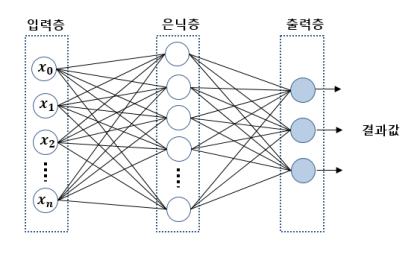

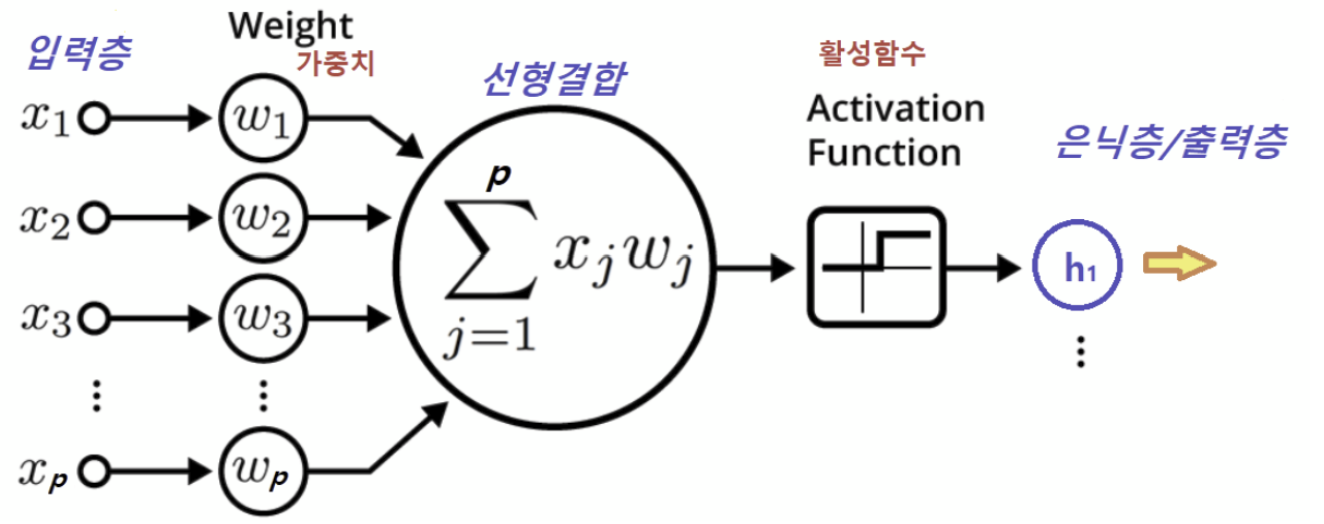

### MLP란 사람의 신경망에서 착안한 컴퓨터의 스스로 학습법이다.<br><br>

### 입력층에 하나하나의 특징들이 들어간다. <br>위에서는 대략 [0, 1, 0...1] 이렇게 말했지만 원래는 [0.1231241241.... , 0.2424232...] 이런식이다.<br> 이런 하나의 노드들과 weight 가중치와 곱해져서 선형으로 결합한다.<br><br>

### nn(neural network는 신경망이라는 뜻이다. <br>nn은 선형의 데이터만 처리가 가능하다 그래서 아날로그 데이터 디지털 데이터 모두 선형인 경우에만 학습이 가능한 것이다. <Br>선형으로 만들어 주는 과정이 입력층 -> 은닉층이다<br><br>

### 여기서 활성함수가 의미하는게 threshold이다. 임계값을 설정하는 것.<br>예를 들어 ReLU 같은 경우에는 0이하는 전부 0으로 취급 <br>sigmoid 같은 경우에는 로지스틱 함수라고 해서 아래의 사진으로 대체하겠다. <br><br> 이렇게 여러가지 활성함수가 있고 우리의 데이터는 어떤 활성함수가 성능을 높게 가져오는지 모르기 때문에 여러가지 함수를 바꿔가며 실험해볼 예정이다.

## sigmoid 함수

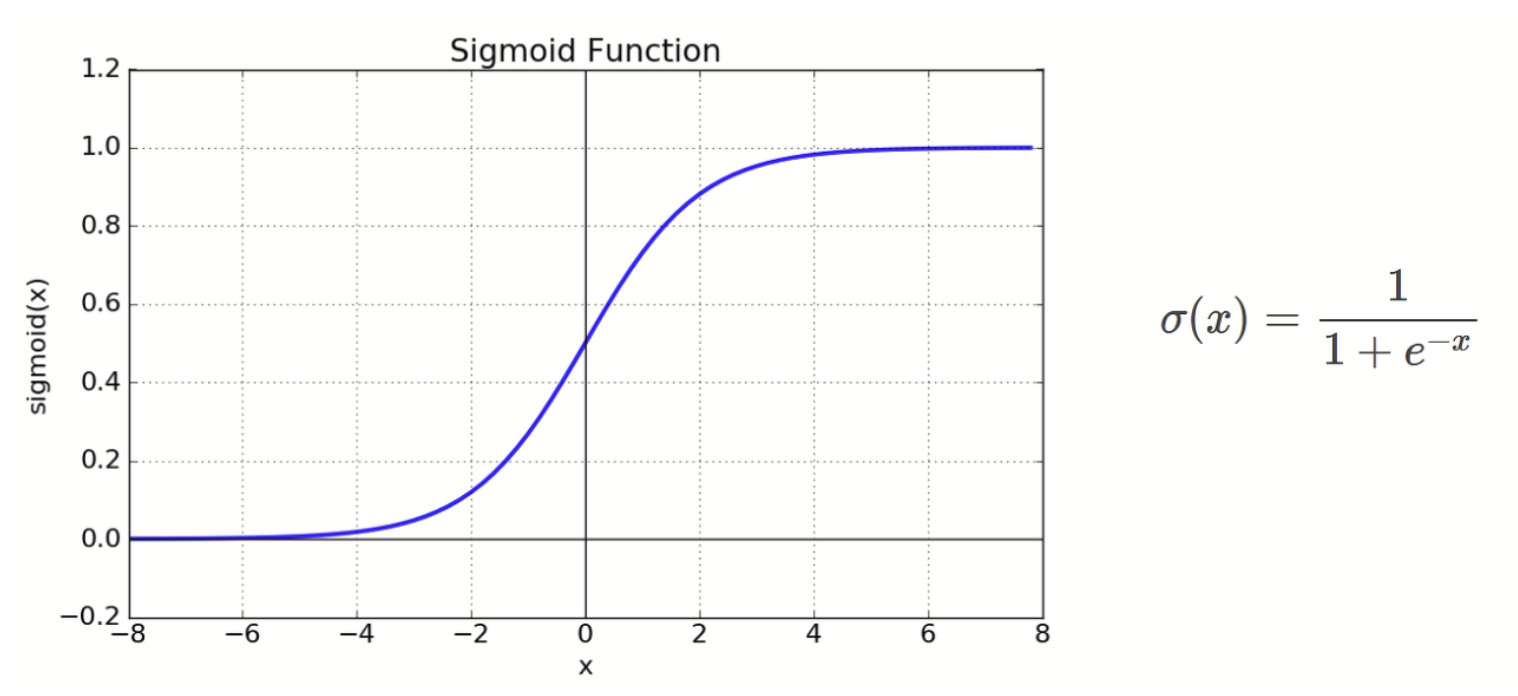

## ReLU 함수 & Leakly ReLU

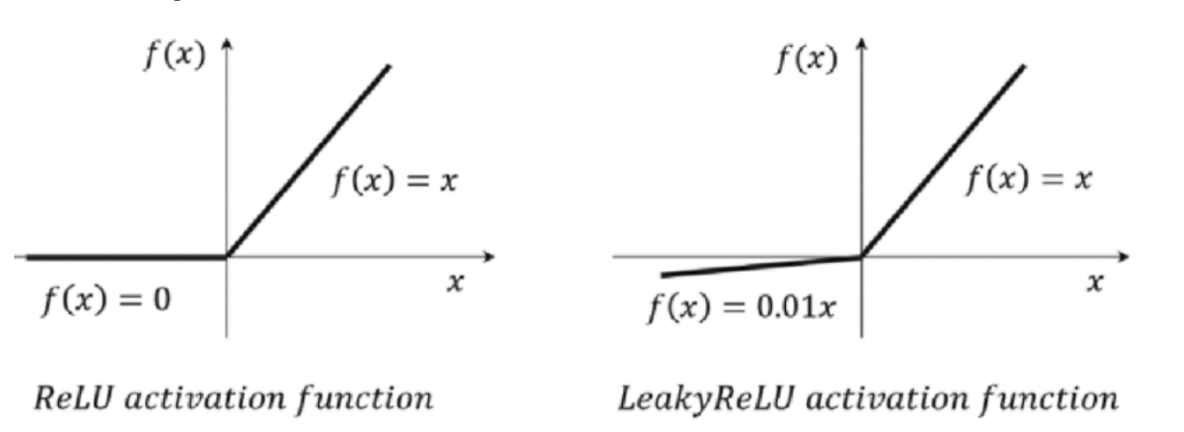

### ReLU의 특징

입력값이 0보다 클 경우 그대로 출력
입력값이 0보다 작을 경우엔 함숫값이 0
0보다 작을 시 0으로 만들어 버리기 때문에 이 값들은 다음 층(Layer)로 전달되지 않는다.
양수일 때는 도함수가 1이고 음수면면 도함수가 0이 된다.
sigmoid, tanh 함수보다 학습이 훨씬 빨라진다.
CNN(Convolution Neural Network)에서 자주 쓰인다.

## Tanh 함수

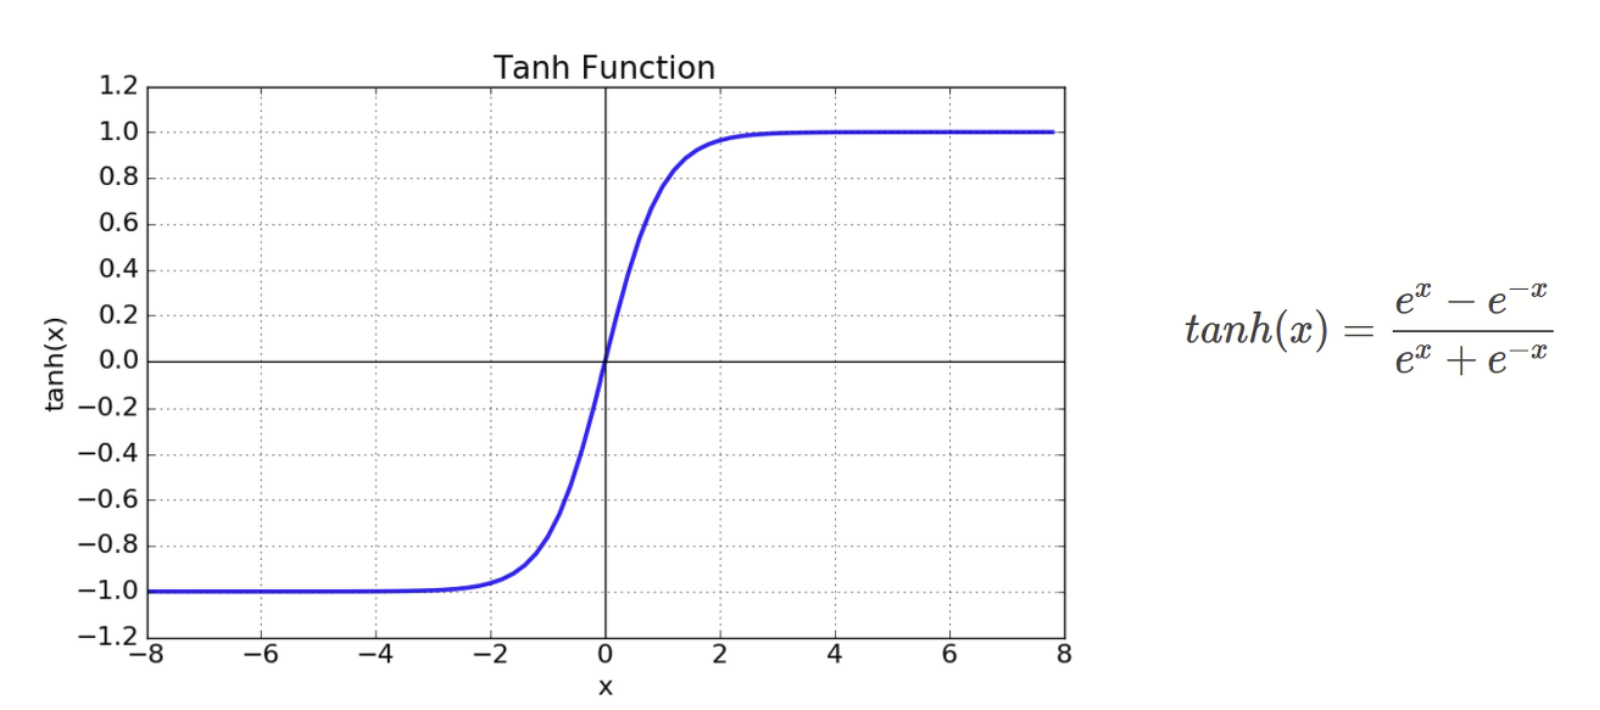

# MLP 구현 부분

In [11]:
# Multi Layer Perceptron 학습 클래스 (적절한 test_size를 찾고 난 후에 이 곳의 ReLU부분 수정 예정)

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import LeakyReLU
import torch
import torch.nn as nn
import torch.nn.functional as F


class LightCRNN(nn.Module):
    def __init__(self, input_dim=CONFIG.N_MFCC, num_classes=CONFIG.N_CLASSES):
        super(LightCRNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.gru = nn.GRU(32, 32, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, lengths):
        # x shape: (batch, input_dim, time)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        x = x.transpose(1, 2)  # (batch, time, channels)

        # Pack the sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # RNN layer
        x_packed, _ = self.gru(x_packed)

        # Unpack the sequence
        x, _ = nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)

        # Global average pooling
        x = torch.sum(x, dim=1) / lengths.unsqueeze(1).float().to(x.device)

        # Fully connected layer
        x = self.dropout(x)
        x = self.fc(x)

        return torch.sigmoid(x)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch, time, hidden_dim)
        attention_weights = F.softmax(self.attention(x).squeeze(-1), dim=1)
        # attention_weights shape: (batch, time)
        context_vector = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)
        # context_vector shape: (batch, hidden_dim)
        return context_vector

class ImprovedLightCRNN(nn.Module):
    def __init__(self, input_dim=CONFIG.N_MFCC, num_classes=CONFIG.N_CLASSES):
        super(ImprovedLightCRNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.gru = nn.GRU(128, 128, bidirectional=True, batch_first=True, num_layers=2, dropout=0.2)
        self.attention = AttentionLayer(256)  # 256 because of bidirectional GRU

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x, lengths):
        # x shape: (batch, input_dim, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.transpose(1, 2)  # (batch, time, channels)

        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        x_packed, _ = self.gru(x_packed)
        x, _ = nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)

        x = self.attention(x)  # (batch, hidden_dim*2)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return torch.sigmoid(x)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class LightweightCRNN(nn.Module):
    def __init__(self, input_dim=CONFIG.N_MFCC, num_classes=CONFIG.N_CLASSES):
        super(LightweightCRNN, self).__init__()

        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.se = SEBlock(64)

        self.gru = nn.GRU(64, 64, bidirectional=True, batch_first=True, num_layers=2, dropout=0.2)

        self.attention = nn.Sequential(
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, lengths):
        # x shape: (batch, input_dim, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se(x)

        x = x.transpose(1, 2)  # (batch, time, channels)

        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        x_packed, _ = self.gru(x_packed)
        x, _ = nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)

        # Attention mechanism
        attention_weights = F.softmax(self.attention(x).squeeze(-1), dim=1)
        x = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)

        x = self.dropout(x)
        x = self.fc(x)

        return torch.sigmoid(x)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedMLP(nn.Module):
    def __init__(self, input_dim=CONFIG.N_MFCC, num_classes=CONFIG.N_CLASSES):
        super(ImprovedMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim * 100, 512)  # Assuming a fixed length of 100 for MFCC features
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, lengths):
        # x shape: (batch, input_dim, time)
        x = x[:, :, :100]  # Truncate or pad to fixed length of 100
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

In [40]:
class EnhancedMLP(nn.Module):
    def __init__(self, input_dim=CONFIG.N_MFCC, num_classes=CONFIG.N_CLASSES):
        super(EnhancedMLP, self).__init__()
        self.input_dim = input_dim

        # 1D Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)

        # Attention layer
        self.attention = AttentionLayer(256)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 256)  # Changed from 512 to 256
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.4)

        # Layer normalization
        self.ln1 = nn.LayerNorm(256)  # Changed from 512 to 256
        self.ln2 = nn.LayerNorm(256)
        self.ln3 = nn.LayerNorm(128)

    def forward(self, x, lengths):
        # x shape: (batch, input_dim, time)

        # Apply 1D convolutions
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Apply attention
        x = x.transpose(1, 2)  # (batch, time, channels)
        x = self.attention(x)

        # Fully connected layers with residual connections
        residual = x
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = x + residual

        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)

        x = self.fc4(x)
        return torch.sigmoid(x)

# 딥러닝 학습

In [14]:
# # 딥러닝 학습부분 (중요)

# from sklearn.metrics import roc_auc_score
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch.optim.lr_scheduler import CosineAnnealingLR


# def train(model, optimizer, train_loader, val_loader, device):
#     model.to(device)
#     criterion = nn.BCELoss().to(device)
#     #scheduler = OneCycleLR(optimizer, max_lr=CONFIG.LR, epochs=CONFIG.N_EPOCHS, steps_per_epoch=len(train_loader))
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

#     best_val_score = 0
#     best_model = None

#     accumulation_steps = 4

#     for epoch in range(1, CONFIG.N_EPOCHS+1):
#         model.train()
#         train_loss = []
#         optimizer.zero_grad()
#         for features, labels, lengths in tqdm(iter(train_loader)):
#             features = features.to(device)
#             labels = labels.to(device)
#             #lengths = torch.tensor(lengths).to(device)
#             #lengths = torch.tensor(lengths)
#             lengths = lengths.to(device)

#             optimizer.zero_grad()

#             output = model(features, lengths)
#             loss = criterion(output, labels)
#             loss = loss / accumulation_steps

#             loss.backward()
#             optimizer.step()
#             scheduler.step()

#             train_loss.append(loss.item())

#         _val_loss, _val_score = validation(model, criterion, val_loader, device)
#         _train_loss = np.mean(train_loss)
#         print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val AUC : [{_val_score:.5f}]')

#         if best_val_score < _val_score:
#             best_val_score = _val_score
#             best_model = model

#     return best_model

# def multiLabel_AUC(y_true, y_scores):
#     auc_scores = []
#     for i in range(y_true.shape[1]):
#         auc = roc_auc_score(y_true[:, i], y_scores[:, i])
#         auc_scores.append(auc)
#     mean_auc_score = np.mean(auc_scores)
#     return mean_auc_score

# def validation(model, criterion, val_loader, device):
#     model.eval()
#     val_loss, all_labels, all_probs = [], [], []

#     with torch.no_grad():
#         for features, labels, lengths in tqdm(iter(val_loader)):
#             features = features.to(device)
#             labels = labels.to(device)
#             #lengths = torch.tensor(lengths).to(device)
#             lengths = torch.tensor(lengths)

#             probs = model(features, lengths)

#             loss = criterion(probs, labels)

#             val_loss.append(loss.item())

#             all_labels.append(labels.cpu().numpy())
#             all_probs.append(probs.cpu().numpy())

#     _val_loss = np.mean(val_loss)

#     all_labels = np.concatenate(all_labels, axis=0)
#     all_probs = np.concatenate(all_probs, axis=0)

#     auc_score = multiLabel_AUC(all_labels, all_probs)

#     return _val_loss, auc_score

In [57]:
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import numpy as np
from tqdm import tqdm

def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    best_val_score = 0
    best_model = None

    accumulation_steps = 24

    for epoch in range(1, CONFIG.N_EPOCHS+1):
        model.train()
        train_loss = []
        optimizer.zero_grad()
        for features, labels, lengths in tqdm(iter(train_loader)):
            features = features.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            output = model(features, lengths)
            loss = criterion(output, labels)
            loss = loss / accumulation_steps

            loss.backward()

            if (epoch * len(train_loader) + len(train_loss) + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            train_loss.append(loss.item() * accumulation_steps)

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val AUC : [{_val_score:.5f}]')

        scheduler.step(_val_score)

        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model.state_dict()
            torch.save(best_model, f'best_model_epoch_{epoch}.pth')

    model.load_state_dict(best_model)
    return model

def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for features, labels, lengths in tqdm(iter(val_loader)):
            features = features.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            probs = model(features, lengths)

            loss = criterion(probs, labels)

            val_loss.append(loss.item())

            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    _val_loss = np.mean(val_loss)

    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)

    auc_score = multiLabel_AUC(all_labels, all_probs)

    return _val_loss, auc_score

In [58]:
# 모델 초기화 후 실제로 훈련을 진행하는 과정

#model = MLP()
#model = ImprovedMLP()
#model = LightCRNN()

# model = LightweightCRNN()
# optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LR, weight_decay=1e-5)

model = ImprovedMLP()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CONFIG.LR)
infer_model = train(model, optimizer, train_loader, val_loader, device)

100%|██████████| 174/174 [00:00<00:00, 182.14it/s]


Epoch [1], Train Loss : [0.68499] Val Loss : [0.69468] Val AUC : [0.72772]


100%|██████████| 174/174 [00:00<00:00, 177.33it/s]


Epoch [2], Train Loss : [0.66733] Val Loss : [0.69422] Val AUC : [0.73030]


100%|██████████| 174/174 [00:01<00:00, 173.64it/s]


Epoch [3], Train Loss : [0.65883] Val Loss : [0.69387] Val AUC : [0.73133]


100%|██████████| 174/174 [00:01<00:00, 171.77it/s]


Epoch [4], Train Loss : [0.65520] Val Loss : [0.69556] Val AUC : [0.72952]


100%|██████████| 174/174 [00:00<00:00, 181.27it/s]

Epoch [5], Train Loss : [0.65150] Val Loss : [0.69390] Val AUC : [0.73041]


In [29]:
from sklearn.model_selection import KFold

# KFold 객체 생성
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=CONFIG.SEED)

# 데이터 준비 함수 수정
def prepare_data(df):
    #features, labels = get_mfcc_feature(df, True, augment=True)
    features, labels = train_mfcc, train_labels
    return features, labels

# 전체 데이터셋 준비
all_features, all_labels = prepare_data(df)

# 학습 및 검증 루프 수정
def train_with_kfold(model_class, device):
    models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(all_features)):
        print(f"Fold {fold+1}/{n_splits}")

        # 데이터 분할
        train_features = [all_features[i] for i in train_idx]
        train_labels = [all_labels[i] for i in train_idx]
        val_features = [all_features[i] for i in val_idx]
        val_labels = [all_labels[i] for i in val_idx]

        # 데이터셋 및 데이터 로더 생성
        train_dataset = CustomDataset(train_features, train_labels)
        val_dataset = CustomDataset(val_features, val_labels)

        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

        # 모델 초기화
        #model = ImprovedMLP()
        model = ImprovedMLP()
        optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LR, weight_decay=1e-5)

        # 모델 학습
        trained_model = train(model, optimizer, train_loader, val_loader, device)
        models.append(trained_model)

    return models

# 테스트 데이터 준비 (val데이터 아님) <br>
## 5만번 반복 <br>
### 이 과정은 만약 한번 했다면 그 다음 위쪽 수정하고 진행할 때는 훈련데이터만 특징추출하고 이부분은 다시 안해도됨 어차피 테스트 데이터를 바꾸진 않기 때문.

In [18]:
# 테스트 데이터 준비
test = pd.read_csv('./test.csv')
test_mfcc = get_mfcc_feature(test, False)
test_dataset = CustomDataset(test_mfcc, train_mode=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

50000it [23:18, 35.75it/s]


# 실제 훈련시킨 모델에 테스트 진행

In [30]:
#테스트 데이터에 대한 예측 수행

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(iter(test_loader)):
            features, lengths = batch  # 테스트 데이터는 항상 2개의 요소만 반환

            features = features.to(device)
            lengths = lengths.to(device)

            probs = model(features, lengths)

            probs = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [31]:
preds = inference(infer_model, test_loader, device)

100%|██████████| 521/521 [00:01<00:00, 297.45it/s]


## 앙상블 러닝

In [53]:
# def create_ensemble():
#     models = []
#     model_configs = [
#         {"hidden_dim": 128},
#         {"hidden_dim": 256},
#         {"hidden_dim": 512}
#     ]

#     # 이미 준비된 train_mfcc와 train_labels를 사용
#     features, labels = all_features, all_labels
#     kfold = KFold(n_splits=5, shuffle=True, random_state=CONFIG.SEED)

#     for fold, (train_idx, val_idx) in enumerate(kfold.split(features), 1):
#         print(f"Fold {fold}/5")

#         train_features = [features[i] for i in train_idx]
#         train_labelses = [labels[i] for i in train_idx]
#         val_features = [features[i] for i in val_idx]
#         val_labels = [labels[i] for i in val_idx]

#         train_dataset = CustomDataset(train_features, train_labelses)
#         val_dataset = CustomDataset(val_features, val_labels)

#         train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
#         val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

#         for config in model_configs:
#             model = LightweightCRNN()  # hidden_dim 파라미터 제거
#             optimizer = optim.AdamW(model.parameters(), lr=CONFIG.LR, weight_decay=1e-5)
#             trained_model = train(model, optimizer, train_loader, val_loader, device)
#             models.append(trained_model)

#     return models

def create_ensemble():
    models = []
    model_configs = [
        {"hidden_dim": 128},
        {"hidden_dim": 256},
        {"hidden_dim": 512}
    ]

    features, labels = all_features, all_labels
    kfold = KFold(n_splits=5, shuffle=True, random_state=CONFIG.SEED)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(features), 1):
        print(f"Fold {fold}/5")

        train_features = [features[i] for i in train_idx]
        train_labelses = [labels[i] for i in train_idx]
        val_features = [features[i] for i in val_idx]
        val_labels = [labels[i] for i in val_idx]

        train_dataset = CustomDataset(train_features, train_labelses)
        val_dataset = CustomDataset(val_features, val_labels)

        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        for config in model_configs:
            model = ImprovedMLP()  # MLP 모델 사용
            optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LR)
            trained_model = train(model, optimizer, train_loader, val_loader, device)
            models.append(trained_model)

    return models


def ensemble_inference(models, test_loader, device):
    predictions = []
    with torch.no_grad():
        for batch in tqdm(iter(test_loader)):
            if len(batch) == 2:  # Test mode
                features, lengths = batch
            else:  # Training mode (this case shouldn't occur, but added for safety)
                features, _, lengths = batch

            features = features.to(device)
            lengths = lengths.to(device)

            probs = torch.zeros((features.shape[0], CONFIG.N_CLASSES)).to(device)
            for model in models:
                model.to(device)
                model.eval()
                probs += model(features, lengths)

            probs /= len(models)
            probs = probs.cpu().numpy()
            predictions += probs.tolist()
    return predictions

# 앙상블 모델 생성 및 추론
ensemble_models = create_ensemble()
ensemble_preds = ensemble_inference(ensemble_models, test_loader, device)

Fold 1/5


100%|██████████| 162/162 [00:04<00:00, 33.63it/s]


Epoch [1], Train Loss : [0.63457] Val Loss : [0.63102] Val AUC : [0.78982]


100%|██████████| 162/162 [00:02<00:00, 65.80it/s]


Epoch [2], Train Loss : [0.61749] Val Loss : [0.60975] Val AUC : [0.81150]


100%|██████████| 162/162 [00:02<00:00, 65.75it/s]


Epoch [3], Train Loss : [0.60605] Val Loss : [0.52558] Val AUC : [0.82211]


100%|██████████| 162/162 [00:02<00:00, 65.41it/s]


Epoch [4], Train Loss : [0.46555] Val Loss : [0.49038] Val AUC : [0.84638]


100%|██████████| 162/162 [00:02<00:00, 65.13it/s]


Epoch [5], Train Loss : [0.42604] Val Loss : [0.42741] Val AUC : [0.88332]


100%|██████████| 162/162 [00:02<00:00, 65.48it/s]


Epoch [1], Train Loss : [0.63971] Val Loss : [0.61972] Val AUC : [0.81138]


100%|██████████| 162/162 [00:02<00:00, 66.66it/s]


Epoch [2], Train Loss : [0.62103] Val Loss : [0.60922] Val AUC : [0.81150]


100%|██████████| 162/162 [00:02<00:00, 66.03it/s]


Epoch [3], Train Loss : [0.61338] Val Loss : [0.61864] Val AUC : [0.80942]


100%|██████████| 162/162 [00:02<00:00, 66.92it/s]


Epoch [4], Train Loss : [0.60365] Val Loss : [0.52897] Val AUC : [0.82671]


100%|██████████| 162/162 [00:02<00:00, 66.85it/s]


Epoch [5], Train Loss : [0.46129] Val Loss : [0.42422] Val AUC : [0.88881]


100%|██████████| 162/162 [00:02<00:00, 66.44it/s]


Epoch [1], Train Loss : [0.64610] Val Loss : [0.61907] Val AUC : [0.80313]


100%|██████████| 162/162 [00:02<00:00, 65.59it/s]


Epoch [2], Train Loss : [0.62210] Val Loss : [0.61004] Val AUC : [0.81273]


100%|██████████| 162/162 [00:02<00:00, 65.87it/s]


Epoch [3], Train Loss : [0.59963] Val Loss : [0.49298] Val AUC : [0.82490]


100%|██████████| 162/162 [00:02<00:00, 66.62it/s]


Epoch [4], Train Loss : [0.46719] Val Loss : [0.45851] Val AUC : [0.86493]


100%|██████████| 162/162 [00:02<00:00, 66.87it/s]


Epoch [5], Train Loss : [0.43351] Val Loss : [0.42414] Val AUC : [0.88580]
Fold 2/5


100%|██████████| 162/162 [00:02<00:00, 63.09it/s]


Epoch [1], Train Loss : [0.63551] Val Loss : [0.62270] Val AUC : [0.80738]


100%|██████████| 162/162 [00:02<00:00, 65.38it/s]


Epoch [2], Train Loss : [0.61720] Val Loss : [0.62831] Val AUC : [0.79458]


100%|██████████| 162/162 [00:02<00:00, 65.94it/s]


Epoch [3], Train Loss : [0.61100] Val Loss : [0.60560] Val AUC : [0.81529]


100%|██████████| 162/162 [00:02<00:00, 65.90it/s]


Epoch [4], Train Loss : [0.60743] Val Loss : [0.59980] Val AUC : [0.82010]


100%|██████████| 162/162 [00:02<00:00, 65.22it/s]


Epoch [5], Train Loss : [0.59731] Val Loss : [0.58276] Val AUC : [0.82897]


100%|██████████| 162/162 [00:02<00:00, 64.45it/s]


Epoch [1], Train Loss : [0.63858] Val Loss : [0.61828] Val AUC : [0.80462]


100%|██████████| 162/162 [00:02<00:00, 65.97it/s]


Epoch [2], Train Loss : [0.61920] Val Loss : [0.61091] Val AUC : [0.81004]


100%|██████████| 162/162 [00:02<00:00, 65.16it/s]


Epoch [3], Train Loss : [0.58060] Val Loss : [0.54790] Val AUC : [0.81968]


100%|██████████| 162/162 [00:02<00:00, 65.51it/s]


Epoch [4], Train Loss : [0.45797] Val Loss : [0.42695] Val AUC : [0.87912]


100%|██████████| 162/162 [00:02<00:00, 64.82it/s]


Epoch [5], Train Loss : [0.42485] Val Loss : [0.46868] Val AUC : [0.87375]


100%|██████████| 162/162 [00:02<00:00, 63.97it/s]


Epoch [1], Train Loss : [0.64164] Val Loss : [0.62155] Val AUC : [0.80089]


100%|██████████| 162/162 [00:02<00:00, 63.83it/s]


Epoch [2], Train Loss : [0.62289] Val Loss : [0.63044] Val AUC : [0.78928]


100%|██████████| 162/162 [00:02<00:00, 64.98it/s]


Epoch [3], Train Loss : [0.61459] Val Loss : [0.60461] Val AUC : [0.81482]


100%|██████████| 162/162 [00:02<00:00, 65.04it/s]


Epoch [4], Train Loss : [0.57352] Val Loss : [0.50727] Val AUC : [0.81985]


100%|██████████| 162/162 [00:02<00:00, 64.23it/s]


Epoch [5], Train Loss : [0.45427] Val Loss : [0.42528] Val AUC : [0.88442]
Fold 3/5


100%|██████████| 162/162 [00:02<00:00, 63.98it/s]


Epoch [1], Train Loss : [0.63646] Val Loss : [0.62279] Val AUC : [0.80535]


100%|██████████| 162/162 [00:02<00:00, 66.50it/s]


Epoch [2], Train Loss : [0.61862] Val Loss : [0.61166] Val AUC : [0.80828]


100%|██████████| 162/162 [00:02<00:00, 66.67it/s]


Epoch [3], Train Loss : [0.61101] Val Loss : [0.81380] Val AUC : [0.79202]


100%|██████████| 162/162 [00:02<00:00, 66.61it/s]


Epoch [4], Train Loss : [0.46719] Val Loss : [0.55961] Val AUC : [0.83807]


100%|██████████| 162/162 [00:02<00:00, 66.30it/s]


Epoch [5], Train Loss : [0.42845] Val Loss : [0.40371] Val AUC : [0.89488]


100%|██████████| 162/162 [00:02<00:00, 65.22it/s]


Epoch [1], Train Loss : [0.63982] Val Loss : [0.62261] Val AUC : [0.80372]


100%|██████████| 162/162 [00:02<00:00, 66.93it/s]


Epoch [2], Train Loss : [0.62001] Val Loss : [0.60696] Val AUC : [0.81305]


100%|██████████| 162/162 [00:02<00:00, 66.97it/s]


Epoch [3], Train Loss : [0.58160] Val Loss : [0.51453] Val AUC : [0.82703]


100%|██████████| 162/162 [00:02<00:00, 66.70it/s]


Epoch [4], Train Loss : [0.45207] Val Loss : [0.44309] Val AUC : [0.87732]


100%|██████████| 162/162 [00:02<00:00, 65.59it/s]


Epoch [5], Train Loss : [0.42539] Val Loss : [0.39971] Val AUC : [0.89600]


100%|██████████| 162/162 [00:02<00:00, 66.07it/s]


Epoch [1], Train Loss : [0.64704] Val Loss : [0.63512] Val AUC : [0.78978]


100%|██████████| 162/162 [00:02<00:00, 66.76it/s]


Epoch [2], Train Loss : [0.62491] Val Loss : [0.62015] Val AUC : [0.80189]


100%|██████████| 162/162 [00:02<00:00, 66.77it/s]


Epoch [3], Train Loss : [0.61498] Val Loss : [0.60515] Val AUC : [0.81374]


100%|██████████| 162/162 [00:02<00:00, 66.06it/s]


Epoch [4], Train Loss : [0.51323] Val Loss : [0.43774] Val AUC : [0.87559]


100%|██████████| 162/162 [00:02<00:00, 65.43it/s]


Epoch [5], Train Loss : [0.44129] Val Loss : [0.40931] Val AUC : [0.89335]
Fold 4/5


100%|██████████| 162/162 [00:02<00:00, 62.67it/s]


Epoch [1], Train Loss : [0.63612] Val Loss : [0.61854] Val AUC : [0.80553]


100%|██████████| 162/162 [00:02<00:00, 65.52it/s]


Epoch [2], Train Loss : [0.61903] Val Loss : [0.61946] Val AUC : [0.79986]


100%|██████████| 162/162 [00:02<00:00, 65.78it/s]


Epoch [3], Train Loss : [0.60726] Val Loss : [0.90755] Val AUC : [0.79237]


100%|██████████| 162/162 [00:02<00:00, 62.59it/s]


Epoch [4], Train Loss : [0.45395] Val Loss : [0.56867] Val AUC : [0.78406]


100%|██████████| 162/162 [00:02<00:00, 64.72it/s]


Epoch [5], Train Loss : [0.41862] Val Loss : [0.45711] Val AUC : [0.87680]


100%|██████████| 162/162 [00:02<00:00, 65.98it/s]


Epoch [1], Train Loss : [0.63859] Val Loss : [0.68095] Val AUC : [0.75880]


100%|██████████| 162/162 [00:02<00:00, 65.35it/s]


Epoch [2], Train Loss : [0.61946] Val Loss : [0.60877] Val AUC : [0.81209]


100%|██████████| 162/162 [00:02<00:00, 63.36it/s]


Epoch [3], Train Loss : [0.61136] Val Loss : [0.60660] Val AUC : [0.81254]


100%|██████████| 162/162 [00:02<00:00, 64.83it/s]


Epoch [4], Train Loss : [0.57508] Val Loss : [0.46053] Val AUC : [0.83016]


100%|██████████| 162/162 [00:02<00:00, 65.98it/s]


Epoch [5], Train Loss : [0.45070] Val Loss : [0.43067] Val AUC : [0.87956]


100%|██████████| 162/162 [00:02<00:00, 66.24it/s]


Epoch [1], Train Loss : [0.64713] Val Loss : [0.61941] Val AUC : [0.80248]


100%|██████████| 162/162 [00:02<00:00, 65.15it/s]


Epoch [2], Train Loss : [0.62262] Val Loss : [0.61125] Val AUC : [0.81078]


100%|██████████| 162/162 [00:02<00:00, 64.48it/s]


Epoch [3], Train Loss : [0.61317] Val Loss : [0.62145] Val AUC : [0.79987]


100%|██████████| 162/162 [00:02<00:00, 65.67it/s]


Epoch [4], Train Loss : [0.54252] Val Loss : [0.48815] Val AUC : [0.82093]


100%|██████████| 162/162 [00:02<00:00, 65.55it/s]


Epoch [5], Train Loss : [0.45336] Val Loss : [0.50271] Val AUC : [0.85090]
Fold 5/5


100%|██████████| 162/162 [00:02<00:00, 63.82it/s]


Epoch [1], Train Loss : [0.63699] Val Loss : [0.63242] Val AUC : [0.79552]


100%|██████████| 162/162 [00:02<00:00, 65.07it/s]


Epoch [2], Train Loss : [0.61956] Val Loss : [0.60855] Val AUC : [0.80831]


100%|██████████| 162/162 [00:02<00:00, 65.40it/s]


Epoch [3], Train Loss : [0.59129] Val Loss : [0.55004] Val AUC : [0.82039]


100%|██████████| 162/162 [00:02<00:00, 65.67it/s]


Epoch [4], Train Loss : [0.44912] Val Loss : [0.42369] Val AUC : [0.88663]


100%|██████████| 162/162 [00:02<00:00, 66.15it/s]


Epoch [5], Train Loss : [0.42212] Val Loss : [0.42294] Val AUC : [0.89054]


100%|██████████| 162/162 [00:02<00:00, 64.67it/s]


Epoch [1], Train Loss : [0.64194] Val Loss : [0.61769] Val AUC : [0.80392]


100%|██████████| 162/162 [00:02<00:00, 65.35it/s]


Epoch [2], Train Loss : [0.62214] Val Loss : [0.60702] Val AUC : [0.80940]


100%|██████████| 162/162 [00:02<00:00, 65.89it/s]


Epoch [3], Train Loss : [0.51191] Val Loss : [0.47483] Val AUC : [0.84703]


100%|██████████| 162/162 [00:02<00:00, 65.06it/s]


Epoch [4], Train Loss : [0.44051] Val Loss : [1.24206] Val AUC : [0.75254]


100%|██████████| 162/162 [00:02<00:00, 65.65it/s]


Epoch [5], Train Loss : [0.42459] Val Loss : [0.40553] Val AUC : [0.89454]


100%|██████████| 162/162 [00:02<00:00, 64.34it/s]


Epoch [1], Train Loss : [0.64542] Val Loss : [0.60991] Val AUC : [0.81512]


100%|██████████| 162/162 [00:02<00:00, 65.54it/s]


Epoch [2], Train Loss : [0.62127] Val Loss : [0.60784] Val AUC : [0.81549]


100%|██████████| 162/162 [00:02<00:00, 64.73it/s]


Epoch [3], Train Loss : [0.61348] Val Loss : [0.60003] Val AUC : [0.81817]


100%|██████████| 162/162 [00:02<00:00, 66.00it/s]


Epoch [4], Train Loss : [0.58719] Val Loss : [0.45875] Val AUC : [0.82889]


100%|██████████| 162/162 [00:02<00:00, 64.73it/s]


Epoch [5], Train Loss : [0.46177] Val Loss : [0.48670] Val AUC : [0.86413]


100%|██████████| 521/521 [00:46<00:00, 11.17it/s]


# 제출 부분

## baseline_submit.csv라는 파일이 왼쪽에 생성됨

### 왼쪽 위에 코랩 파일들 한번 새로고침 해주고 baseline_submit.csv파일 다운로드 후 <br>데이콘 제출란에 csv파일만 제출 (하루에 5번 가능) <br>점수가 0에 가까울 수록 리더보드에 상위로 등재됨 = 실제 정답과 많이 다르지 않다.

In [54]:
# 제출 부분

submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = ensemble_preds
submit.head()
submit.to_csv('./baseline_submit_ensemble.csv', index=False)


# 결과 눈으로 확인

## fake일 확률 0.33 = 33%, true일 확률 0.72 = 72%
### 결과는 둘이 더해서 100이 되진 않는다.<br>모델의 정확도를 위해 하나의 test데이터에 대해 fake일 확률 구하고 true일 확률을 구했다.
#### 만약 정확도를 신경 안썼다면 fake만 구하고 true는 1- fake로 했을 것이다.

In [22]:
submit

,id,fake,real
0,TEST_00000,0.003993,0.995653
1,TEST_00001,0.003993,0.995653
2,TEST_00002,0.003993,0.995653
3,TEST_00003,0.003993,0.995653
4,TEST_00004,0.003993,0.995652
...,...,...,...
49995,TEST_49995,0.003993,0.995653
49996,TEST_49996,0.003993,0.995653
49997,TEST_49997,0.003993,0.995653
49998,TEST_49998,0.003993,0.995652


# 모델 평가 점수 (리더보드 용) // 그냥 참고용 사용은 안함

In [23]:
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import pandas as pd


def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")

    submission_df = submission_df[submission_df.iloc[:, 0].isin(answer_df.iloc[:, 0])]
    submission_df.index = range(submission_df.shape[0])

    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns[1:]:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)


    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)


    brier_scores = []
    ece_scores = []

    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns[1:]:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values

        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)

        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)

    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)

    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece

    return combined_score

# 모델의 성능을 향상시키는 법

- test_size 조정 (07/03 기준 test_size가 0.1 < 0.2 < 0.3 순서로 좋다)
- 활섬화 함수 변경
- 정규화 진행 (전처리 단계에서 통일성 부여 = 미리 다듬기)
- 훈련 데이터 수 늘리기
- train/validation 과정에서 다른 방법 사용하기 0.8/0.2로 나누는 방법 말고 ex. Cross-Validation, LOOCV, K-Fold cross validation
- Bootstrap

## Cross-Validation

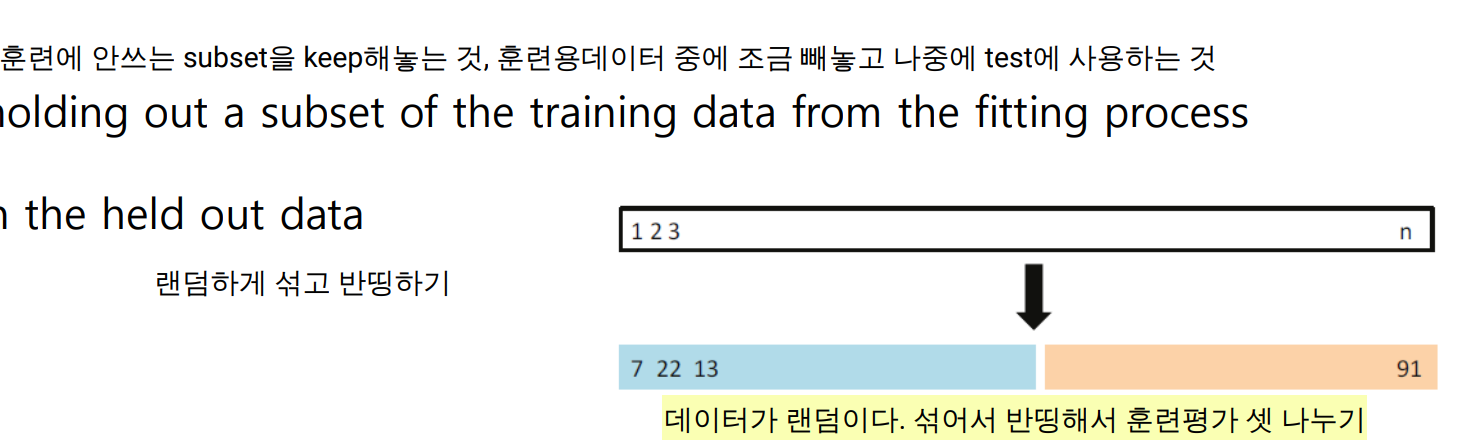

## LOOCV

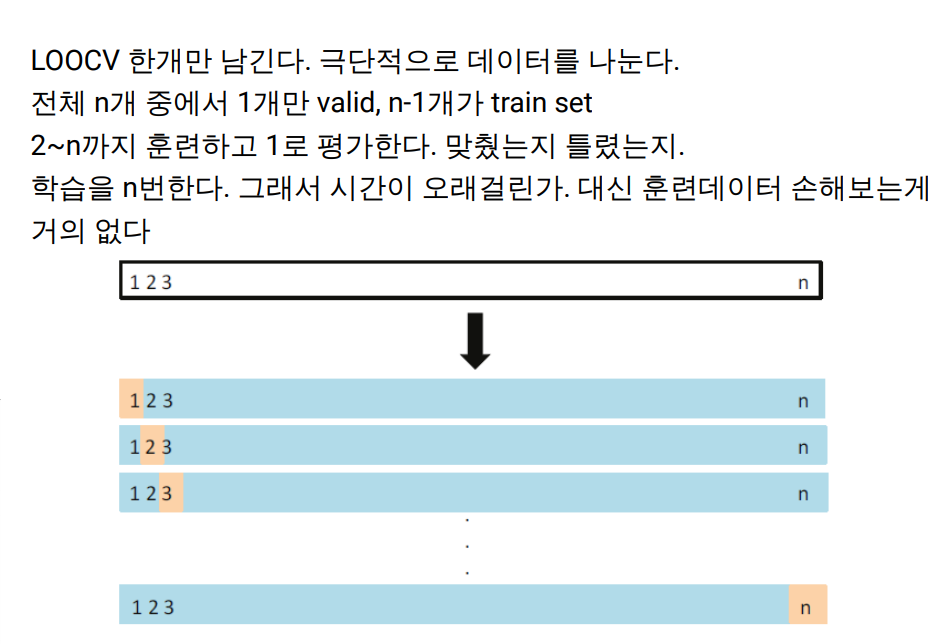

## K-Fold Cross Validation

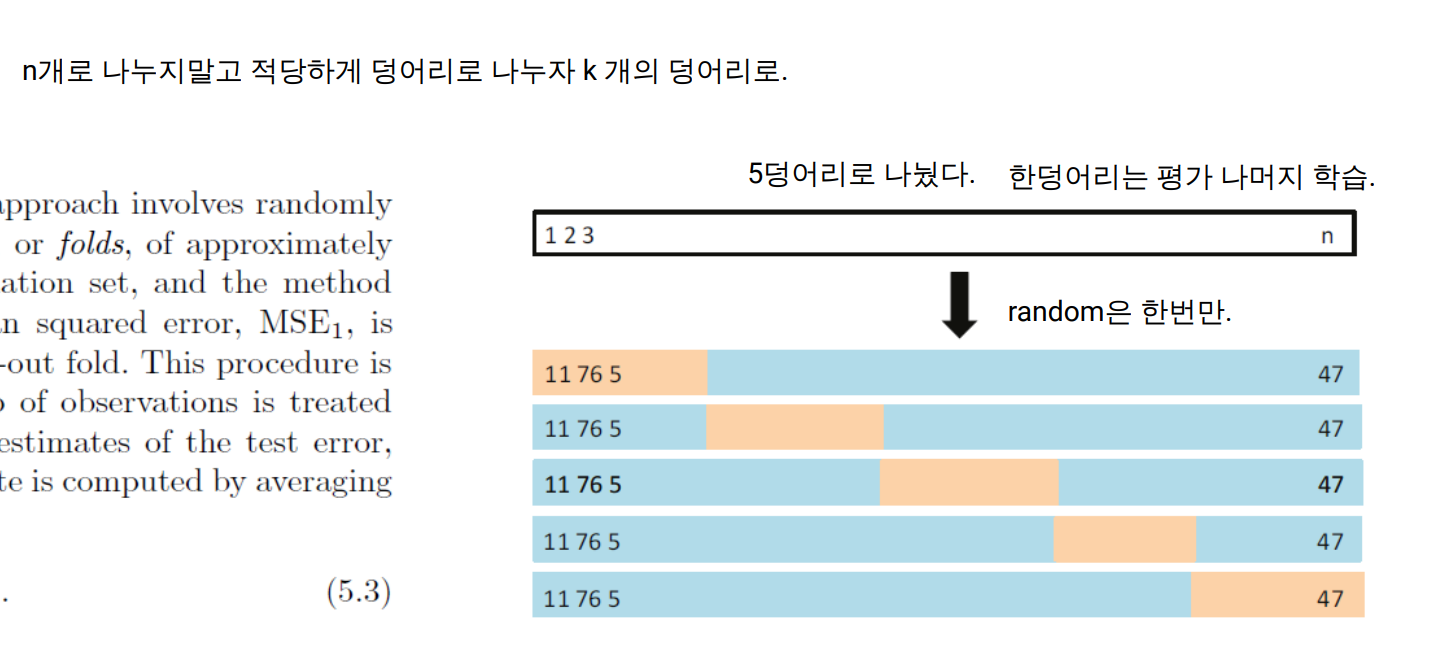

## Bootstrap

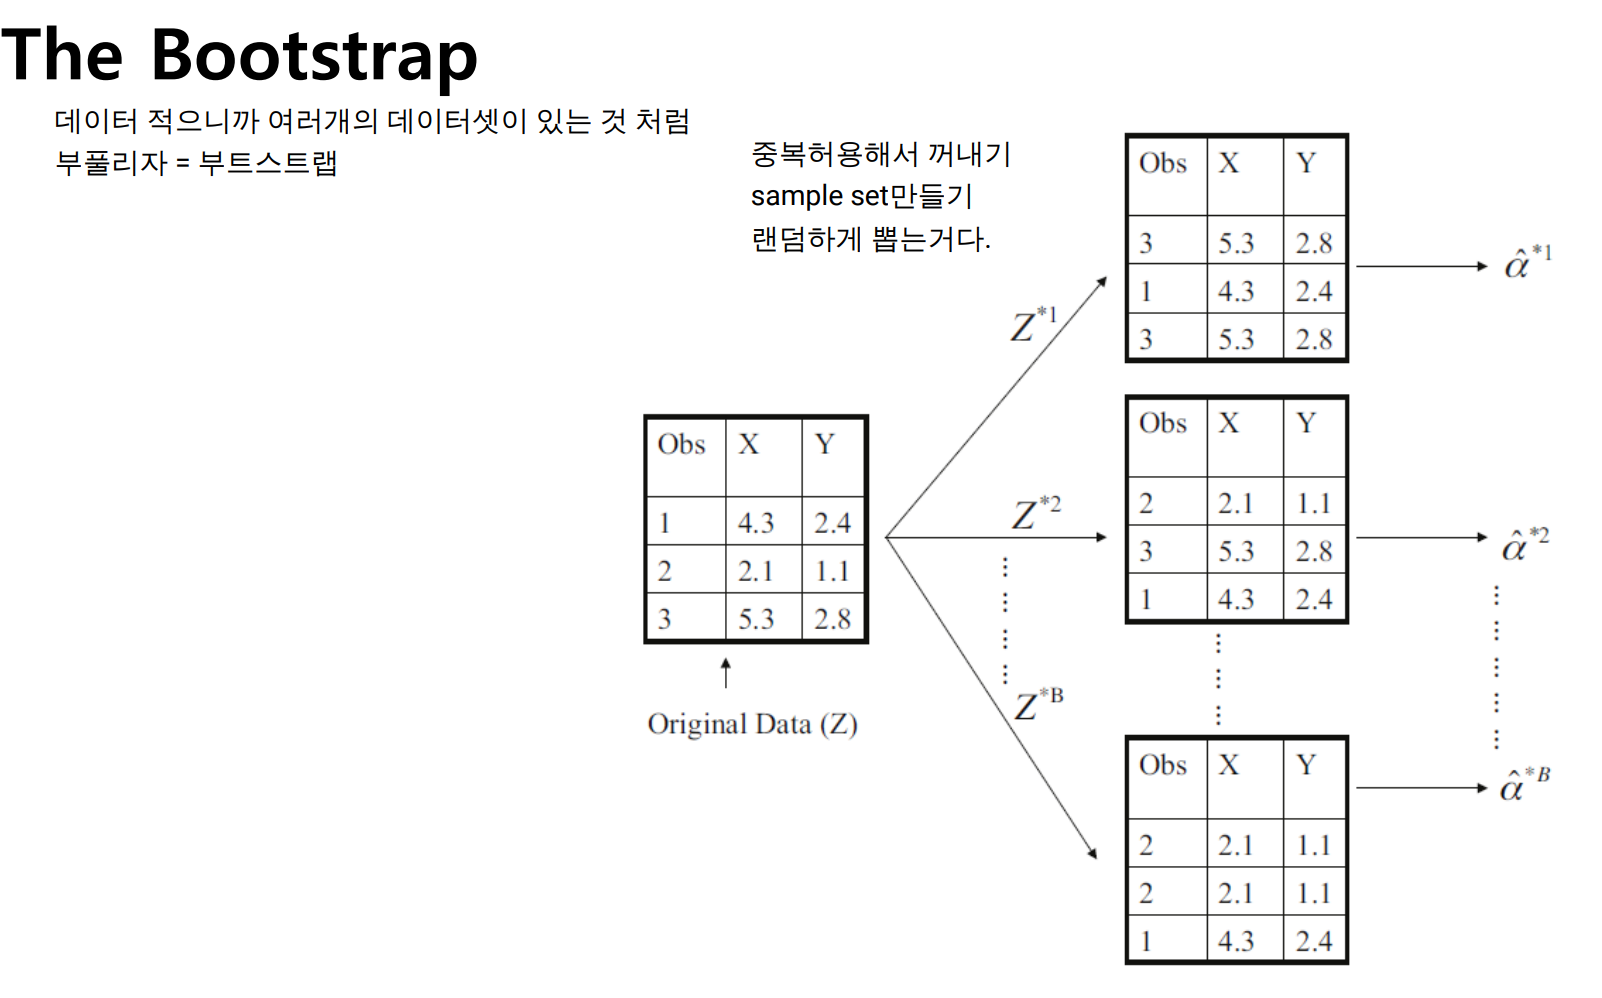